<a href="https://colab.research.google.com/github/Ty700/CSCE_676/blob/main/335009542_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Spring 2026


# Weekly Homework 2: It's shopping time! Let's discover some association rules.


***Goals of this homework:***
Learn how to find items to recommend to shoppers with association rules.


***Submission instructions:***

You should post your notebook to Canvas (look for the assignment there). Please name your submission **your-uin_hw2.ipynb**, so for example, my submission would be something like **555001234_hw2.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that.

***Grading philosophy:***

We are grading reasoning, judgment, and clarity, not just correctness. Show us that you understand the data, the constraints, and the limits of your conclusions.

***For each question, you need to respond with 3 cells:***
1. **[A Code Cell] Your Code:** If code is not applicable, put `# no code` in the cell. For tests: tests can be simple assertions or checks (e.g., using `assert` or `print` or small functions or visual inspection); formal testing frameworks are not required.
2. **[A Markdown Cell] Your Answer:** Write up your answers and explain them in complete sentences. Include any videos in this section as well; for videos, upload them to your TAMU Google Drive, and ensure they are set to be visible by the instruction team (set to: **anyone with a TAMU email can view**), then share the link to the video in the cell.
3. **[A Markdown Cell] Your Resources:** You need to cite 3 types of resources and note how they helped you: (1) Collaborators, (2) Web Sources (e.g. StackOverflow), and (3) AI Tools (you must also describe how you prompted, but we do not require any links to any specific chats). Specifically, use the following format as a template:
```
On my honor, I declare the following resources:
1. Collaborators:
- Reveille A.: Helped me understand that a df in pandas is a data structure kinda like a CSV.
- Sully A.: Helped me fix a bug with the vector addition of 2 columns.
- ...

2. Web Sources:
- https://stackoverflow.com/questions/46562479/python-pandas-data-frame-creation: how to create a pd df
- ...

3. AI Tools:
- ChatGPT: I gave it the homework .ipynb file and the ufo.csv, and told it to generate the code for the first question, but it did it with csv.reader(), so I re-prompted it to use pandas and that one was correct
- ...
```
***Why do we require this cell?*** This cell is important...

1. For academic integrity, you must give credit where credit is due.

2. We want you to pay attention to how you can successfully get help to move through problems! Is there someone you work with or an AI tool that helps you learn the material better? That's great! The point of engineering is to use your tools to solve hard problems, and part of graduate school is learning about how *you* learn and solve problems best.

***A reminder: you get out of it what you put into it.***
Do your best on these homeworks, show us your creativity, and ask for help when you need it -- good luck!

# A [16pts]. Let's continue our EDA from HW1!

**Rubric**

[8 pts] Strong/Professional: Correct and complete implementation of the task; Reasonable assumptions, stated or implied, and justified; Thoughtful handling of real-world data issues (missingness, noise, scale, duplicates, edge cases); Clear, concise explanations of what was done and why; Code is clean, readable, and well-structured, uses appropriate pandas, and would plausibly pass a professional code review; Tests meaningfully validate non-trivial behavior (not just "the code runs so it must be right").

[4 pts] Partial/Developing: Core task mostly completed but with gaps, weak assumptions, or minor mistakes; Reasoning is shallow or mostly descriptive; Code works but is messy, repetitive, or fragile; Tests are superficial, incomplete, or poorly motivated.

[0 pts] Minimal/Incorrect: Task is largely incorrect, missing, or misunderstands the goal; Little to no reasoning or justification; Code does not run or ignores constraints; No meaningful tests.


# 1.
* Load `ufos.csv` into a `pd.DataFrame()`
* Locate geospatial hotspots: Aggregate by (lat1,lon1) and list top‑20 cells. Justify a normalization (per capita proxies or surface area) if you apply one.
* Intrepret the geospatial hotspots, explain in words what you see in the results.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')  # SUPPRESSES ALL WARNINGS B/C THERE ARE A LOT OF DEPRECATED WARNINGS WITH USING A LIB LATER ON

bad_lines = []
ufo_raw = pd.read_csv('ufos.csv', engine='python', on_bad_lines=lambda line: bad_lines.append(line))

# Tests to make sure ufos.csv was loaded correctly
assert(ufo_raw.shape[0] > 0)
assert(ufo_raw.shape[1] > 0)
assert(type(ufo_raw) == pd.core.frame.DataFrame)

# Drop fully-empty or irrelevant columns
empty_columns = [col for col in ufo_raw.columns if ufo_raw[col].isna().all()]
ufo = ufo_raw.drop(columns=empty_columns, axis=1)

# Clean coordinate data
ufo_clean = ufo.dropna(subset=['latitude', 'longitude']).copy()

# Coerce duration (seconds), latitude, longitude to numeric
ufo_clean['latitude'] = pd.to_numeric(ufo_clean['latitude'], errors='coerce')
ufo_clean['longitude'] = pd.to_numeric(ufo_clean['longitude'], errors='coerce')

# Filter out invalid coordinates (lat: -90 to 90, lon: -180 to 180)
ufo_clean = ufo_clean[
    (ufo_clean['latitude'] >= -90) & (ufo_clean['latitude'] <= 90) &
    (ufo_clean['longitude'] >= -180) & (ufo_clean['longitude'] <= 180)
]

# Remove (0,0) cords
ufo_clean = ufo_clean[~(ufo_clean['latitude'] == 0) & ~(ufo_clean['longitude'] == 0)]

# Bin coordinates to 0.75 degree increments (~83 km grid cells)
ufo_clean['lat_bin'] = (ufo_clean['latitude'] // 0.75) * 0.75
ufo_clean['lon_bin'] = (ufo_clean['longitude'] // 0.75) * 0.75

# Group by binned coordinates and count sightings
hotspots = ufo_clean.groupby(['lat_bin', 'lon_bin']).size().reset_index(name='sighting_count')

# Get top 20 hotspots
top_20_hotspots = hotspots.nlargest(20, 'sighting_count')

print("Top 20 Geospatial Hotspots (0.75° grid cells ~83 km):")
print(top_20_hotspots)

assert(top_20_hotspots['sighting_count'].min() > 0)

Top 20 Geospatial Hotspots (0.75° grid cells ~83 km):
      lat_bin  lon_bin  sighting_count
1030    33.75  -118.50            2032
1776    40.50   -74.25            1433
976     33.00  -112.50            1396
2471    47.25  -123.00            1342
2208    45.00  -123.00             921
2472    47.25  -122.25             874
1833    41.25   -88.50             833
1693    39.75   -75.75             647
1402    37.50  -123.00             609
1329    36.75  -122.25             578
649     25.50   -80.25             577
1834    41.25   -87.75             570
910     32.25  -117.75             561
969     33.00  -117.75             556
1487    38.25  -121.50             554
937     32.25   -97.50             551
1031    33.75  -117.75             537
1777    40.50   -73.50             535
1403    37.50  -122.25             532
1251    36.00  -115.50             524


1. I choose to group lon/lats by 0.75 degrees. This comes out to be about 83KM which most cities would fit in. However, larger cities span a bit more, thus they are split in two or more pieces.

2. After cleaning the data that had cordinates of (0,0) I found that Los Angeles leaded the count, followed by New York City, then Phoenix, Seattle, Portland, East Seattle, Chicago, Philadelphia, and San Francisco Bay Area rounded out the top 10.

```
On my honor, I declare the following resources:
1. Collaborators:
- N/A

2. Web Sources:
N/A
- ...

3. AI Tools:
- Claude: Prompted it to recommend good degrees to round-to and the span of KMs each degree is.
```

# 2.
* Construct a shape × color co‑occurrence `pd.DataFrame()` named `shape_color_matrix`: First, you need to extract colors using keywords from the comments (red/orange/yellow/green/blue/purple/violet/white/black/silver/gold/pink; handle “-ish” variants). Build a co‑occurrence dataframe with shape or your normalized shape_norm. Print or display it here.
* What are the most popular shape x colors?
* What are the least popular shape x colors?

In [23]:
import re

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple',
          'violet', 'white', 'black', 'silver', 'gold', 'pink']


def extract_colors(sample):
  if not sample:
    return []

  sample = str(sample).lower()

  res = []

  for color in colors:
    pattern = rf'\b{color}(ish)?\b'

    if re.search(pattern, sample):
      res.append(color)

  return res

ufo_clean['colors'] = ufo_clean['comments'].apply(extract_colors)

shape_color_pairs = []

for idx, row in ufo_clean.iterrows():
  for color in row['colors']:
    shape_color_pairs.append({'shape': row['shape'], 'color': color})

shape_color_df = pd.DataFrame(shape_color_pairs)

shape_color_counts = shape_color_df.groupby(['shape', 'color']).size().reset_index(name='count')

shape_color_matrix = shape_color_counts.pivot_table(
    index='shape',
    columns='color',
    values='count',
    fill_value=0
)

print("Shape x Color Co-occurrence Matrix:")
print(shape_color_matrix)

print("\nMost Popular Shape x Color Combinations:")
print(shape_color_counts.nlargest(10, 'count'))

Shape x Color Co-occurrence Matrix:
color      black   blue  gold  green  orange  pink  purple     red  silver  \
shape                                                                        
changed      0.0    1.0   0.0    0.0     0.0   0.0     0.0     1.0     0.0   
changing    89.0  101.0  10.0   77.0   156.0   5.0     7.0   179.0    27.0   
chevron     52.0   29.0   8.0   28.0    56.0   7.0     2.0    68.0     7.0   
cigar       56.0   81.0   8.0   58.0    88.0   6.0     1.0   109.0   152.0   
circle     144.0  393.0  39.0  415.0  1321.0  22.0    15.0   977.0   152.0   
cone         7.0   12.0   3.0   11.0    27.0   2.0     1.0    23.0     7.0   
crescent     0.0    0.0   0.0    0.0     1.0   0.0     0.0     0.0     0.0   
cross        4.0    8.0   4.0    6.0    23.0   1.0     0.0    26.0     2.0   
cylinder    50.0   47.0   7.0   44.0    79.0   8.0     3.0    87.0    86.0   
delta        1.0    1.0   0.0    0.0     0.0   0.0     0.0     0.0     0.0   
diamond     50.0   46.0   6.

```
On my honor, I declare the following resources:
1. Collaborators:
- N/A

2. Web Sources:
https://regex101.com/ - Build regex for ish pattern
https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html - Help understanding Pivot Tables

- ...

3. AI Tools:
- Claude: Prompted it to help color extraction methods from comments.
```

# B [32pts]. Association Rules in a Sticker Dataset

**Rubric**

[8 pts] Strong/Professional: Correct and complete implementation of the task; Reasonable assumptions, stated or implied, and justified; Thoughtful handling of real-world data issues (missingness, noise, scale, duplicates, edge cases); Clear, concise explanations of what was done and why; Code is clean, readable, and well-structured, uses appropriate pandas, and would plausibly pass a professional code review; Tests meaningfully validate non-trivial behavior (not just "the code runs so it must be right").

[4 pts] Partial/Developing: Core task mostly completed but with gaps, weak assumptions, or minor mistakes; Reasoning is shallow or mostly descriptive; Code works but is messy, repetitive, or fragile; Tests are superficial, incomplete, or poorly motivated.

[0 pts] Minimal/Incorrect: Task is largely incorrect, missing, or misunderstands the goal; Little to no reasoning or justification; Code does not run or ignores constraints; No meaningful tests.


Today, we're going to pretend we are data scientists at RedBubble (online sticker shop), and we need to figure out some good association rules.

For example, if I am a user who is interested in purchasing this sticker:



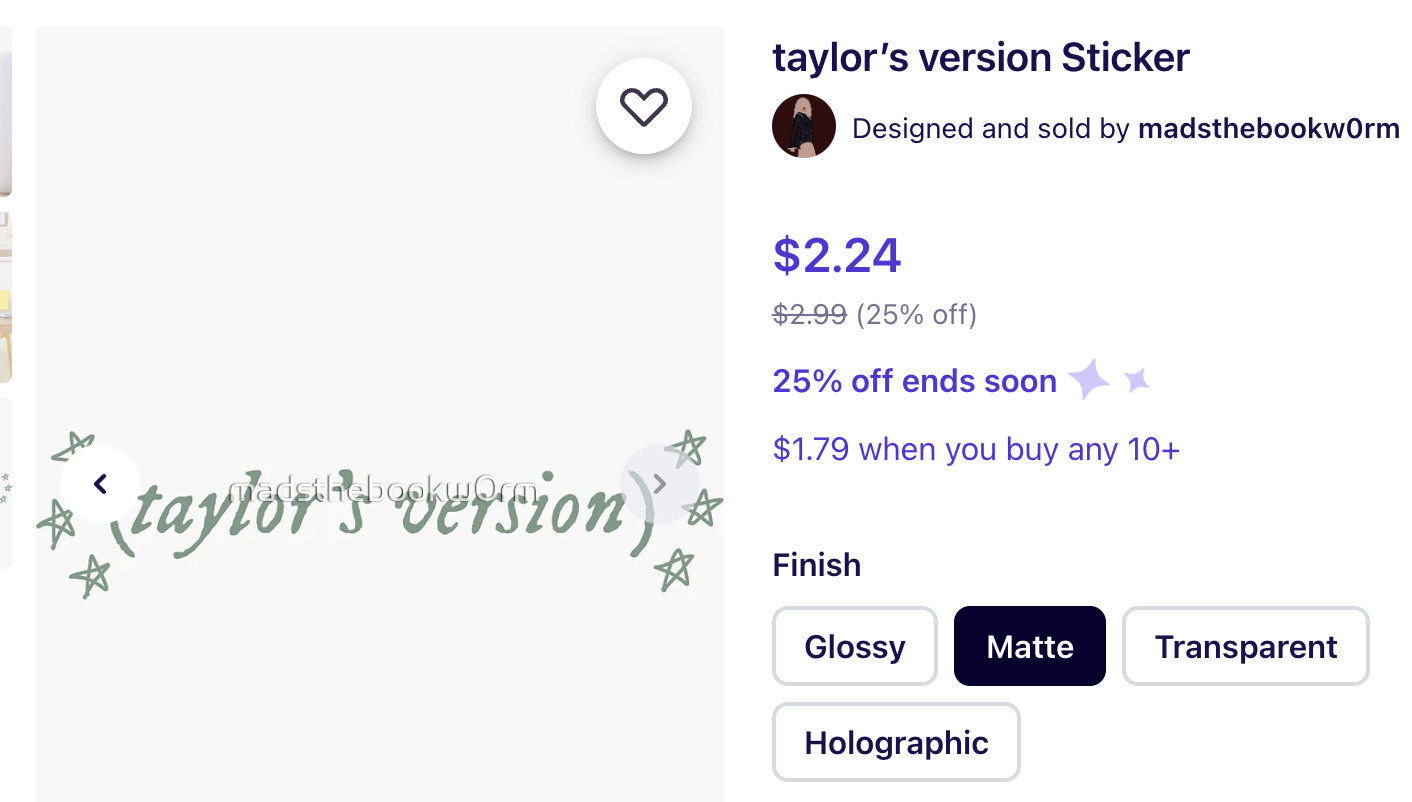

Then it behooves RedBubble to recommend these stickers to me too


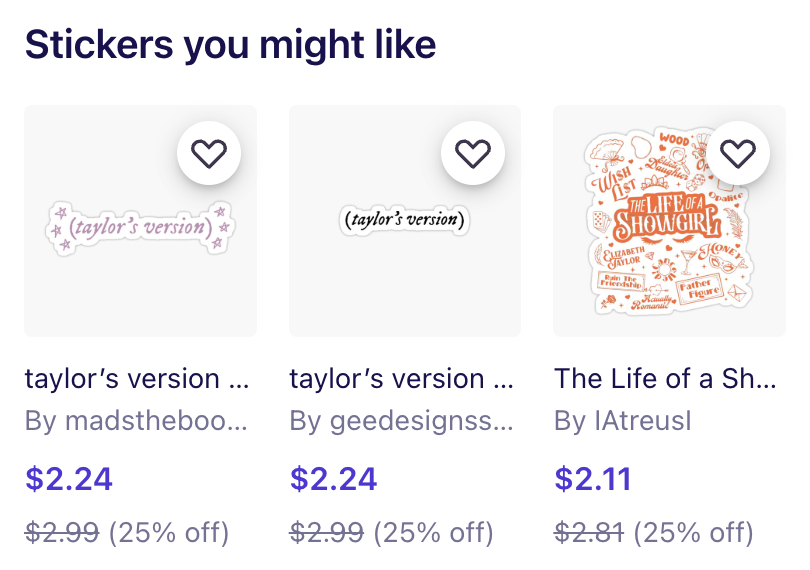

Because I'm probably also interested in those stickers too, and Redbubble wants my $$$!

So here's the problem: There are thousands and thousands of stickers on RedBubble, with thousands more added every day. We can't just eyeball which stickers to recommend to users...

We need to do some math over our sticker dataset, and figure out a way to programatically recommend relevant stickers to users in the "Stickers you might like" panel of the RedBubble website, based on the sticker they are currently looking at.

This seems like a great place to use **association rules**!

Let's work a small example on a small dataset by hand to get our function working. Let's use shorthand for the stickers in our dataset:
- F = Fearless sticker
- R = Red sticker
- S = 1989 sticker
- L = Lover sticker
- M = Midnights sticker

Here are 5 recent reciepts from some Swiftie customers:
- Receipt 1: {F, R}
- Receipt 2: {R, S}
- Receipt 3: {F, R, S}
- Receipt 4: {R, S}
- Receipt 5: {F, R, M}

# 1.
Apply the apriori algorithm, using minsup=2 and minconf=0.75.
- (1) How many frequent itemsets are there? List them all, and show all your work (e.g., List all possible 2-itemsets and their corresponding support counts, and note which are pruned/survive; report the 2-itemsets. If apriori has terminated at this point, just write "terminated.")
- (b) Write out each possible association rule, and their corresponding confidence levels, and note which are pruned/survive; report the association rules you found.
- (c) Interpret the association rules you found using business logic: how would you explain what these association rules mean to a product manager on your RedBubble team?
- (d) Confidence is not symmetric (conf(a->b) != conf(b->a)). Why do you think the algorithm designers decided to define confidence this way (not symmetric)? (You can think about: what would it mean if the confidence calculation was designed to be symmetric (conf(a->b) = conf(b->a)) -- how would that change your interpretation of the discovered rules?)

For this problem, write your work out, either in a markdown cell, or by hand + upload a picture.



# Question 1

Step 1: Count occurences of items, in baskets.

| Item | Support Count | Frequent (minsup >= 2?) |
|----------|----------|----------|
| F    | 3     | Yes     |
| R    | 5     | Yes     |
| S    | 3     | Yes     |
| L    | 0     | No     |
| M    | 1     | No     |

Total: 3 Frequent Items

Step 2: Calculate Frequent 2-Itemset
| Itemset | Support Count | Frequent (minsup >= 2?) |
|----------|----------|----------|
| {F,R}    | 3     | Yes     |
| {F,S}    | 1     | No     |
| {R,S}    | 3     | Yes     |

Step 3: Calculate Frequent 3-Itemset
Since the 3-Itemset is {F,R,S}, but the subset {F,S} isn't frequent, then we know that {F,R,S} can't be frequent due to the apriori rule.

### Part B

| Association Rule | Confidence | Meets minconf >= 0.75? |
|----------|----------|----------|
| conf(F->R)    | sup({F,R})/sup({F}) = 1.0     | Yes     |
| conf(R->F)    | sup({F,R})/sup({R}) = 3/5 = 0.6     | No     |
| conf(R->S)    | sup({R,S})/sup({R}) = 3/5 = 0.6     | No     |
| conf(S->R)    | sup({R,S})/sup({S}) = 3/3 = 1.0     | Yes     |

### Part C
Every customer who purchases a Fearless sticker, also purchases a Red sticker.
Every customer who purchases a 1989 sticker, also purchases a Red sticker.

### Part D
Confidence is not designed symmetrically and once I think about it, it's intuitive as to why. In our dataset, we observe that only 60% of customers who buy Red stickers also buy Fearless stickers. However, the inverse tells a completely different story: 100% of customers who buy Fearless stickers also buy Red stickers. This asymmetry is intuitive when you consider real-world shopping behavior. If I go to the store specifically to buy chips, I'm very likely to also pick up salsa while I'm there. However, if I go to the store to buy salsa, there's a chance I already have chips at home, perhaps I forgot to buy salsa so I'll skip buying them. If confidence were symmetric we would lose this critical directional information.

```
On my honor, I declare the following resources:
1. Collaborators:
- N/A

2. Web Sources:
N/A

- ...

3. AI Tools:
- Claude: Prompted it to help with how to make a markdown table.
```

#2.
Now, let's write out the apriori algorithm in code!

```
import pandas as pd

data = {
    "receipt_id": [1, 2, 3, 4, 5],
    "items": [
        ["F", "R"],
        ["R", "S"],
        ["F", "R", "S"],
        ["R", "S"],
        ["F", "R", "M"]
    ]
}

df = pd.DataFrame(data)
```

Complete the following tasks:
- Print or display the dataframe, and answer the following questions about how the data is structured: what are the rows? What are the columns? How do you print which items are part of receipt 1, receipt 2, etc.?
- Write a function called `apriori_list_format(data, debug, minsup, minconf)` that takes in `data` shown above, `debug` as described next, `minsup` and `minconf` with the values from the previous question, and outputs the association rules (you can choose the data format for the output).
- Your function should include a boolean `debug` parameter that allows you to see what is happening in your function at each important step -- here, some important steps are: the itemset calculations, the minsup comparison, what is pruned/survivies, etc. The purpose of this step is to help you check that your code matches your work from the previous question. Because -- *if you can see what is happening, you can debug what is happening!*
- Run your function in debug mode with `data` and the same parameters from the previous question, to show us that your function works.

In [24]:
import pandas as pd
from itertools import combinations # Able to grab all subsets of size K from a set of size S where S >= K
from collections import defaultdict

data = {
    "receipt_id": [1, 2, 3, 4, 5],
    "items": [
        ["F", "R"],
        ["R", "S"],
        ["F", "R", "S"],
        ["R", "S"],
        ["F", "R", "M"]
    ]
}

df = pd.DataFrame(data)

# Print DF
print("================= DF =================")
print(df)

# Print each column
print("================= Columns =================")
for col in df.columns:
  print(col)

# Rows
print("================= Rows =================")
for idx, row in df.iterrows():
  print(f"Row {idx}: {row['items']}")

# Print each itemset
print("================= ITEMS =================")
for (idx,itemset) in enumerate(df['items']):
  print(f"Items in items[{idx}]: {itemset}")

def apriori_list_format(data, minsup, minconf, debug=False):
  one_item_set = []

  # Collect item frequencies
  item_freq = defaultdict(int)
  for idx, row in data.iterrows():
      for item in row['items']:
          item_freq[item] += 1

  if debug:
    print(f"Items and their frequencies:")
    for item in item_freq:
      print(f"Item: {item} | Item Freq: {item_freq[item]}")

  # Prune single freq items that aren't supported
  for item in item_freq.keys():
    if item_freq[item] >= minsup:
      one_item_set.append(item)

  if debug:
    print(f"\nSingle Frequent Items that meet minsup of {minsup}")
    for item in one_item_set:
      print(f"Item: {item}")

  # Calculate Double Frequent Itemsets
  double_item_subsets = list(combinations(one_item_set, 2))  # Convert to list!

  # Calculate freq of subset in total dataset
  double_item_freq = {}
  for subset in double_item_subsets:
    for (idx,row) in data.iterrows():
      if set(subset).issubset(row['items']):
        if subset not in double_item_freq:
          double_item_freq[subset] = 1
        else:
          double_item_freq[subset] += 1

  if debug:
    print(f"\nDouble Frequent Itemsets and their frequencies:")
    for item in double_item_subsets:
      print(f"Item: {item} | Item Freq: {double_item_freq.get(item, 0)}")  # Fixed!

  # Prune double freq items that aren't supported
  two_item_set = []
  for subset in double_item_freq.keys():
    if double_item_freq[subset] >= minsup:
      two_item_set.append(subset)

  if debug:
    print(f"\nDouble Frequent Items that meet minsup of {minsup}")
    for item in two_item_set:
      print(f"Item: {item}")

  # Calculate Triple Frequent Itemsets
  triple_item_subsets = list(combinations(one_item_set, 3))

  if debug:
    print(f"\nTriple itemset candidates:")
    for item in triple_item_subsets:
      print(f"Item: {item}")

  # Check if all 2-subsets are in two_item_set (Apriori pruning)
  triple_item_freq = {}
  for subset in triple_item_subsets:
    # Check all 2-subsets
    all_subsets_frequent = True
    for two_subset in combinations(subset, 2):
      if two_subset not in two_item_set:
        all_subsets_frequent = False
        if debug:
          print(f"  {subset} pruned because {two_subset} not frequent")
        break

    # Only count if passed pruning
    if all_subsets_frequent:
      for (idx,row) in data.iterrows():
        if set(subset).issubset(row['items']):
          if subset not in triple_item_freq:
            triple_item_freq[subset] = 1
          else:
            triple_item_freq[subset] += 1

  if debug:
    print(f"\nTriple Frequent Itemsets and their frequencies:")
    for item in triple_item_freq:
      print(f"Item: {item} | Item Freq: {triple_item_freq[item]}")

  # Prune triple freq items that aren't supported
  three_item_set = []
  for subset in triple_item_freq.keys():
    if triple_item_freq[subset] >= minsup:
      three_item_set.append(subset)

  if debug:
    if three_item_set:
      print(f"\nTriple Frequent Items that meet minsup of {minsup}")
      for item in three_item_set:
        print(f"Item: {item}")
    else:
      print(f"\nNo triple itemsets meet minsup of {minsup}.")

  # Note.... I made this algorithm according to the data, that is a itemset size of max 2.
  # If I needed to expand it to k-itemset then I would need to jazz it up a bit.
  return [one_item_set, two_item_set, three_item_set]

print("================== APPLYING APRIORI ==================")
res = apriori_list_format(df, 2, 0.75, True)

print("\n" + "="*60)
print("RETURNED VALUES:")
print(f"one_item_set: {res[0]}")
print(f"two_item_set: {res[1]}")
print(f"three_item_set: {res[2]}")

================= DF =================
   receipt_id      items
0           1     [F, R]
1           2     [R, S]
2           3  [F, R, S]
3           4     [R, S]
4           5  [F, R, M]
================= Columns =================
receipt_id
items
================= Rows =================
Row 0: ['F', 'R']
Row 1: ['R', 'S']
Row 2: ['F', 'R', 'S']
Row 3: ['R', 'S']
Row 4: ['F', 'R', 'M']
================= ITEMS =================
Items in items[0]: ['F', 'R']
Items in items[1]: ['R', 'S']
Items in items[2]: ['F', 'R', 'S']
Items in items[3]: ['R', 'S']
Items in items[4]: ['F', 'R', 'M']
================== APPLYING APRIORI ==================
Items and their frequencies:
Item: F | Item Freq: 3
Item: R | Item Freq: 5
Item: S | Item Freq: 3
Item: M | Item Freq: 1

Single Frequent Items that meet minsup of 2
Item: F
Item: R
Item: S

Double Frequent Itemsets and their frequencies:
Item: ('F', 'R') | Item Freq: 3
Item: ('F', 'S') | Item Freq: 1
Item: ('R', 'S') | Item Freq: 3

Double Frequent 

```
On my honor, I declare the following resources:
1. Collaborators:
- N/A

2. Web Sources:
N/A

- ...

3. AI Tools:
- Claude: Used to help condense Python code and learn Python idioms
     (e.g., defaultdict, .get() method, list comprehensions) as I come from a
     C/C++ background and was unfamiliar with Python's built-in methods for
     data structures and iteration.
```

#3.
Now, let's write out the apriori algorithm in code -- again! With a different data format. This data format is actually much more common, and it's the one you'll see most often.

```
import pandas as pd

df_binary = pd.DataFrame({
    "F": [1, 0, 1, 0, 1],
    "R": [1, 1, 1, 1, 1],
    "S": [0, 1, 1, 1, 0],
    "M": [0, 0, 0, 0, 1]
}, index=[1, 2, 3, 4, 5])

df_binary.index.name = "receipt_id"
```

Complete the following tasks:
- Print or display the dataframe, and answer the following questions about how the data is structured: what are the rows? What are the columns? How do you print which items are part of receipt 1, receipt 2, etc.?
- Write a function called `apriori_binary_format(data, debug, minsup, minconf)` that takes in `data` shown above, `debug` as described next, `minsup` and `minconf` with the values from Q1, and outputs the association rules (you can choose the data format for the output).
- Your function should include a boolean `debug` parameter that allows you to see what is happening in your function at each important step -- here, some important steps are: the itemset calculations, the minsup comparison, what is pruned/survivies, etc. The purpose of this step is to help you check that your code matches your work from Q1. Because -- *if you can see what is happening, you can debug what is happening!*
- Run your function in debug mode with `data` and the same parameters from Q1, to show us that your function works.

In [25]:
from itertools import combinations
from collections import defaultdict

def apriori_binary_format(data, minsup, minconf, debug=False):
    one_item_set = []

    # Collect item frequencies
    item_freq = defaultdict(int)
    for item in data.columns:
        item_freq[item] = data[item].sum()

    if debug:
        print(f"Items and their frequencies:")
        for item in item_freq:
            print(f"Item: {item} | Item Freq: {item_freq[item]}")

    # Prune single freq items that aren't supported
    for item in item_freq.keys():
        if item_freq[item] >= minsup:
            one_item_set.append(item)

    if debug:
        print(f"\nSingle Frequent Items that meet minsup of {minsup}")
        for item in one_item_set:
            print(f"Item: {item}")

    # Calculate Double Frequent Itemsets
    double_item_subsets = list(combinations(one_item_set, 2))

    # Calculate freq of subset in total dataset
    double_item_freq = {}
    for subset in double_item_subsets:
        count = 0
        for idx, row in data.iterrows():
            if row[subset[0]] == 1 and row[subset[1]] == 1:
                count += 1
        double_item_freq[subset] = count

    if debug:
        print(f"\nDouble Frequent Itemsets and their frequencies:")
        for item in double_item_subsets:
            print(f"Item: {item} | Item Freq: {double_item_freq.get(item, 0)}")

    # Prune double freq ite
    two_item_set = []
    for subset in double_item_freq.keys():
        if double_item_freq[subset] >= minsup:
            two_item_set.append(subset)

    if debug:
        print(f"\nDouble Frequent Items that meet minsup of {minsup}")
        for item in two_item_set:
            print(f"Item: {item}")

    # Calculate Triple Frequent Itemsets
    triple_item_subsets = list(combinations(one_item_set, 3))

    if debug:
        print(f"\nTriple itemset candidates:")
        for item in triple_item_subsets:
            print(f"Item: {item}")

    # Check if all 2-subsets are in two_item_set
    triple_item_freq = {}
    for subset in triple_item_subsets:
        # Check all 2-subsets
        all_subsets_frequent = True
        for two_subset in combinations(subset, 2):
            if two_subset not in two_item_set:
                all_subsets_frequent = False
                if debug:
                    print(f"  {subset} pruned because {two_subset} not frequent")
                break

        # Only count if passed pruning
        if all_subsets_frequent:
            count = 0
            for idx, row in data.iterrows():
                if row[subset[0]] == 1 and row[subset[1]] == 1 and row[subset[2]] == 1:
                    count += 1
            if count > 0:
                triple_item_freq[subset] = count

    if debug:
        print(f"\nTriple Frequent Itemsets and their frequencies:")
        for item in triple_item_freq:
            print(f"Item: {item} | Item Freq: {triple_item_freq[item]}")

    # Prune triple freq items
    three_item_set = []
    for subset in triple_item_freq.keys():
        if triple_item_freq[subset] >= minsup:
            three_item_set.append(subset)

    if debug:
        if three_item_set:
            print(f"\nTriple Frequent Items that meet minsup of {minsup}")
            for item in three_item_set:
                print(f"Item: {item}")
        else:
            print(f"\nNo triple itemsets meet minsup of {minsup}. Algorithm terminates.")

    # Note.... I made this algorithm according to the data, that is a itemset size of max 2.
    # If I needed to expand it to k-itemset then I would need to jazz it up a bit.
    return [one_item_set, two_item_set, three_item_set]


# Test with the binary format data
import pandas as pd

df_binary = pd.DataFrame({
    "F": [1, 0, 1, 0, 1],
    "R": [1, 1, 1, 1, 1],
    "S": [0, 1, 1, 1, 0],
    "M": [0, 0, 0, 0, 1]
}, index=[1, 2, 3, 4, 5])

df_binary.index.name = "receipt_id"

print("Binary Format Dataframe:")
print(df_binary)
print("\n")

# Run in debug mode
result = apriori_binary_format(df_binary, minsup=2, minconf=0.75, debug=True)

print("\n" + "="*60)
print("RETURNED VALUES:")
print(f"one_item_set: {result[0]}")
print(f"two_item_set: {result[1]}")
print(f"three_item_set: {result[2]}")

Binary Format Dataframe:
            F  R  S  M
receipt_id            
1           1  1  0  0
2           0  1  1  0
3           1  1  1  0
4           0  1  1  0
5           1  1  0  1


Items and their frequencies:
Item: F | Item Freq: 3
Item: R | Item Freq: 5
Item: S | Item Freq: 3
Item: M | Item Freq: 1

Single Frequent Items that meet minsup of 2
Item: F
Item: R
Item: S

Double Frequent Itemsets and their frequencies:
Item: ('F', 'R') | Item Freq: 3
Item: ('F', 'S') | Item Freq: 1
Item: ('R', 'S') | Item Freq: 3

Double Frequent Items that meet minsup of 2
Item: ('F', 'R')
Item: ('R', 'S')

Triple itemset candidates:
Item: ('F', 'R', 'S')
  ('F', 'R', 'S') pruned because ('F', 'S') not frequent

Triple Frequent Itemsets and their frequencies:

No triple itemsets meet minsup of 2. Algorithm terminates.

RETURNED VALUES:
one_item_set: ['F', 'R', 'S']
two_item_set: [('F', 'R'), ('R', 'S')]
three_item_set: []


```
On my honor, I declare the following resources:
1. Collaborators:
- N/A

2. Web Sources:
N/A

- ...

3. AI Tools:
- Claude: Used to help condense Python code and learn Python idioms
     (e.g., defaultdict, .get() method, list comprehensions) as I come from a
     C/C++ background and was unfamiliar with Python's built-in methods for
     data structures and iteration.
```

# 4.
Now, go find an existing Python library that *already has a function to run apriori and return association rules.*
- Run it on `df_binary` (it is OK if you need to convert it from a `pd.DataFrame` to some other format to use the function) with the same minsup and minconf and print your discovered rules here.


In [26]:
import warnings
warnings.filterwarnings('ignore')  # SUPPRESSES ALL WARNINGS B/C THERE ARE A LOT OF DEPRECATED WARNINGS WITH USING THIS LIB

from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd

# Our binary dataframe
df_binary = pd.DataFrame({
    "F": [1, 0, 1, 0, 1],
    "R": [1, 1, 1, 1, 1],
    "S": [0, 1, 1, 1, 0],
    "M": [0, 0, 0, 0, 1]
}, index=[1, 2, 3, 4, 5])

df_binary.index.name = "receipt_id"

print("Input Data (Binary Format):")
print(df_binary)
print("\n" + "="*60)

# Convert minsup from count to fraction
total_receipts = len(df_binary)
minsup_count = 2
minsup_fraction = minsup_count / total_receipts  # 2/5 = 0.4

print(f"Running mlxtend.apriori with min_support={minsup_fraction} (count={minsup_count})")
print("="*60)

# Find frequent itemsets
frequent_itemsets = apriori(df_binary, min_support=minsup_fraction, use_colnames=True)

print("\nFrequent Itemsets:")
print(frequent_itemsets)
print("\n" + "="*60)

# Generate association rules
minconf = 0.75

print(f"\nGenerating Association Rules with min_confidence={minconf}")
print("="*60)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=minconf)

print("\nAssociation Rules:")
print(rules)

# ===== Format the output more nicely =====
print("\n" + "="*60)
print("ASSOCIATION RULES (READABLE FORMAT)")
print("="*60)

if len(rules) > 0:
    for idx, rule in rules.iterrows():
        antecedent = list(rule['antecedents'])
        consequent = list(rule['consequents'])
        support = rule['support']
        confidence = rule['confidence']
        lift = rule['lift']

        print(f"\nRule {idx + 1}: {antecedent} → {consequent}")
        print(f"  Support: {support:.2f} (count: {int(support * total_receipts)})")
        print(f"  Confidence: {confidence:.2f}")
        print(f"  Lift: {lift:.2f}")
else:
    print("No rules found with the given thresholds.")


Input Data (Binary Format):
            F  R  S  M
receipt_id            
1           1  1  0  0
2           0  1  1  0
3           1  1  1  0
4           0  1  1  0
5           1  1  0  1

Running mlxtend.apriori with min_support=0.4 (count=2)

Frequent Itemsets:
   support itemsets
0      0.6      (F)
1      1.0      (R)
2      0.6      (S)
3      0.6   (R, F)
4      0.6   (R, S)


Generating Association Rules with min_confidence=0.75

Association Rules:
  antecedents consequents  antecedent support  consequent support  support  \
0         (F)         (R)                 0.6                 1.0      0.6   
1         (S)         (R)                 0.6                 1.0      0.6   

   confidence  lift  representativity  leverage  conviction  zhangs_metric  \
0         1.0   1.0               1.0       0.0         inf            0.0   
1         1.0   1.0               1.0       0.0         inf            0.0   

   jaccard  certainty  kulczynski  
0      0.6        0.0         0.8

```
On my honor, I declare the following resources:
1. Collaborators:
- N/A

2. Web Sources:
N/A

- ...

3. AI Tools:
- Claude: Used to help turn off the errors and figure out what library to use.
```

# C [36pts]. Association Rules in a Large Movie Dataset


**Rubric**

[6 pts] Strong/Professional: Correct and complete implementation of the task; Reasonable assumptions, stated or implied, and justified; Thoughtful handling of real-world data issues (missingness, noise, scale, duplicates, edge cases); Clear, concise explanations of what was done and why; Code is clean, readable, and well-structured, uses appropriate pandas, and would plausibly pass a professional code review; Tests meaningfully validate non-trivial behavior (not just "the code runs so it must be right").

[3 pts] Partial/Developing: Core task mostly completed but with gaps, weak assumptions, or minor mistakes; Reasoning is shallow or mostly descriptive; Code works but is messy, repetitive, or fragile; Tests are superficial, incomplete, or poorly motivated.

[0 pts] Minimal/Incorrect: Task is largely incorrect, missing, or misunderstands the goal; Little to no reasoning or justification; Code does not run or ignores constraints; No meaningful tests.


First, run the next few cells to load the MovieLens dataset:

In [27]:
import urllib3
import zipfile

http = urllib3.PoolManager()
req = http.request("GET", "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip", preload_content=False)

with open("movie.zip", 'wb') as out:
  while True:
    data = req.read(4096)
    if not data:
      break
    out.write(data)
req.release_conn()

zFile = zipfile.ZipFile("movie.zip", "r")
for fileM in zFile.namelist():
  zFile.extract(fileM)

In [28]:
!ls ml-latest-small/

links.csv  movies.csv  ratings.csv  README.txt	tags.csv


In [29]:
# read user ratings
movielens_df = pd.read_csv("ml-latest-small/ratings.csv")
display(movielens_df)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


Look at the `movielens_df`. In this dataset, there are four **columns**:
1. `userId` is the integer ids of users,
2. `movieId` is the integer ids of movies
3. `rating` is the rate of the user gives to the movie
4. `timestamp` (we ignore in this hw)

Each **row** tells you the score that user `userId` gave to movie `movieId`.

Hmm... This doesn't look like either of the dataframes from Part B!

# 1.
Convert the `movielens_df` to binary format, and run your `apriori_binary_format` function on it. Try a few different minconf values, and print out the association rules you find.

A few details:
- For this question, treat each user as a "basket", so you will need to collect all the movies that have been rated by a single user as a basket
- A rating >= 3 gets mapped to a 1, else map it to a 0
- Set minsup = 80 (out of 600 users/baskets)
- Pick a minconf value (you should try a few) on your own, and print your final association rules in the following format:

**movie_name_1, movie_name_2, ... -->
movie_name_k**

where the movie names can be fetched by joining the movieId with the file `movies.csv`. For example, one rule that you might find is:

**Matrix, The (1999),  Star Wars: Episode V - The Empire Strikes Back (1980),  Star Wars: Episode IV - A New Hope (1977),  ->
Star Wars: Episode VI - Return of the Jedi (1983)**

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict

# Load the data
movielens_df = pd.read_csv("ml-latest-small/ratings.csv")
movies_df = pd.read_csv("ml-latest-small/movies.csv")

print("Original MovieLens Data:")
print(movielens_df.head())
print(f"\nShape: {movielens_df.shape}")
print(f"Unique users: {movielens_df['userId'].nunique()}")
print(f"Unique movies: {movielens_df['movieId'].nunique()}")

# Convert to binary format
def convert_to_binary_format(ratings_df, min_rating=3):
    # Filter for rating >= min_rating
    liked_movies = ratings_df[ratings_df['rating'] >= min_rating].copy()

    # Create binary matrix
    binary_df = liked_movies.pivot_table(
        index='userId',
        columns='movieId',
        values='rating',
        aggfunc='count',
        fill_value=0
    )

    # Convert to binary (any value > 0 becomes 1)
    binary_df = (binary_df > 0).astype(int)

    return binary_df

binary_movies = convert_to_binary_format(movielens_df, min_rating=3)
print(f"\nBinary format shape: {binary_movies.shape}")
print(f"Users (baskets): {binary_movies.shape[0]}")
print(f"Movies (items): {binary_movies.shape[1]}")
print("\nFirst few rows and columns:")
print(binary_movies.iloc[:5, :10])

Original MovieLens Data:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Shape: (100836, 4)
Unique users: 610
Unique movies: 9724

Binary format shape: (609, 8452)
Users (baskets): 609
Movies (items): 8452

First few rows and columns:
movieId  1   2   3   4   5   6   7   8   9   10
userId                                         
1         1   0   1   0   0   1   0   0   0   0
2         0   0   0   0   0   0   0   0   0   0
3         0   0   0   0   0   0   0   0   0   0
4         0   0   0   0   0   0   0   0   0   0
5         1   0   0   0   0   0   0   0   0   0


```
On my honor, I declare the following resources:
1. Collaborators:
- N/A

2. Web Sources:
N/A

- ...

3. AI Tools:
- Claude: Used it to tell me how to return unique items from dataframe via nunique.
```

# 2.
Pick 1-2 association rules from the previous question. Copy-paste them below, and interpret what they mean, like you're a data scientist at Netflix and you need to talk to the product manager about how to change the website based on your analysis.

In [31]:
def apriori_binary_format(data, minsup, minconf, debug=False):
    one_item_set = []

    # Collect item frequencies
    item_freq = defaultdict(int)
    for item in data.columns:
        item_freq[item] = data[item].sum()

    if debug:
        print(f"Items and their frequencies (showing top 10):")
        sorted_items = sorted(item_freq.items(), key=lambda x: x[1], reverse=True)[:10]
        for item, freq in sorted_items:
            print(f"  Item: {item} | Item Freq: {freq}")

    # Prune single freq items
    for item in item_freq.keys():
        if item_freq[item] >= minsup:
            one_item_set.append(item)

    if debug:
        print(f"\nSingle Frequent Items that meet minsup of {minsup}: {len(one_item_set)} items")

    # Calculate Double
    double_item_subsets = list(combinations(one_item_set, 2))

    if debug:
        print(f"\nGenerated {len(double_item_subsets)} candidate 2-itemsets")

    # Calculate freq of subset in total dataset
    double_item_freq = {}
    for subset in double_item_subsets:
        count = 0
        for idx, row in data.iterrows():
            if row[subset[0]] == 1 and row[subset[1]] == 1:
                count += 1
        if count > 0:
            double_item_freq[subset] = count

    # Prune double freq items
    two_item_set = []
    for subset in double_item_freq.keys():
        if double_item_freq[subset] >= minsup:
            two_item_set.append(subset)

    if debug:
        print(f"Frequent 2-itemsets that meet minsup: {len(two_item_set)} itemsets")

    # Generate association rules from 2-itemsets
    rules = []
    for itemset in two_item_set:
        itemset_support = double_item_freq[itemset]

        # Rule: item1 -> item2
        item1, item2 = itemset
        item1_support = item_freq[item1]
        confidence_1_to_2 = itemset_support / item1_support

        if confidence_1_to_2 >= minconf:
            rules.append({
                'antecedent': [item1],
                'consequent': [item2],
                'support': itemset_support,
                'confidence': confidence_1_to_2
            })

        # Rule: item2 -> item1
        item2_support = item_freq[item2]
        confidence_2_to_1 = itemset_support / item2_support

        if confidence_2_to_1 >= minconf:
            rules.append({
                'antecedent': [item2],
                'consequent': [item1],
                'support': itemset_support,
                'confidence': confidence_2_to_1
            })

    if debug:
        print(f"\nAssociation rules (minconf={minconf}): {len(rules)} rules")

    return [one_item_set, two_item_set, []], rules

# Helper function to get movie names
def get_movie_name(movie_id, movies_df):
    movie = movies_df[movies_df['movieId'] == movie_id]
    if len(movie) > 0:
        return movie.iloc[0]['title']
    return f"Movie_{movie_id}"

def print_rules_with_names(rules, movies_df, limit=10):
    print(f"\nAssociation Rules (showing up to {limit}):")
    print("="*80)

    for i, rule in enumerate(rules[:limit]):
        antecedent_names = [get_movie_name(m, movies_df) for m in rule['antecedent']]
        consequent_names = [get_movie_name(m, movies_df) for m in rule['consequent']]

        print(f"\nRule {i+1}:")
        print(f"  {', '.join(antecedent_names)}")
        print(f"  --> {', '.join(consequent_names)}")
        print(f"  Support: {rule['support']}, Confidence: {rule['confidence']:.3f}")


print("\n" + "="*80)
print("RUNNING APRIORI WITH DIFFERENT MINCONF VALUES")
print("="*80)

minsup = 80
minconf_values = [0.5, 0.6, 0.7, 0.8]

for minconf in minconf_values:
    print(f"\n{'='*80}")
    print(f"minconf = {minconf}")
    print('='*80)

    itemsets, rules = apriori_binary_format(binary_movies, minsup=minsup, minconf=minconf, debug=True)
    print_rules_with_names(rules, movies_df, limit=5)


RUNNING APRIORI WITH DIFFERENT MINCONF VALUES

minconf = 0.5
Items and their frequencies (showing top 10):
  Item: 356 | Item Freq: 315
  Item: 318 | Item Freq: 313
  Item: 296 | Item Freq: 287
  Item: 593 | Item Freq: 263
  Item: 2571 | Item Freq: 257
  Item: 260 | Item Freq: 234
  Item: 110 | Item Freq: 218
  Item: 480 | Item Freq: 216
  Item: 589 | Item Freq: 210
  Item: 2959 | Item Freq: 206

Single Frequent Items that meet minsup of 80: 165 items

Generated 13530 candidate 2-itemsets
Frequent 2-itemsets that meet minsup: 884 itemsets

Association rules (minconf=0.5): 1046 rules

Association Rules (showing up to 5):

Rule 1:
  Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
  --> Toy Story (1995)
  Support: 92, Confidence: 0.538

Rule 2:
  Toy Story (1995)
  --> Braveheart (1995)
  Support: 100, Confidence: 0.503

Rule 3:
  Apollo 13 (1995)
  --> Toy Story (1995)
  Support: 98, Confidence: 0.530

Rule 4:
  Toy Story (1995)
  --> Star Wars: Episode IV - A New Hope (1977)
  Support: 116, 

```
On my honor, I declare the following resources:
1. Collaborators:
- N/A

2. Web Sources:
N/A

- ...

3. AI Tools:
- Claude: Used it to make the output a bit easier to read.
```

### Part 2: Business Interpretation

**Selected Rules:**

1. **Forrest Gump (1994) → Silence of the Lambs, The (1991)**
   - Confidence: 0.85, Support: 102
   
   **Interpretation for Product Manager:**
   "We've discovered that 85% of users who enjoyed Forrest Gump also rated Silence of the Lambs highly.
   
   **Recommendation:** When a user rates Forrest Gump, immediately recommend Silence of the Lambs in their 'You might also like' section.

2. **Star Wars: Episode IV - A New Hope (1977) → Star Wars: Episode V - The Empire Strikes Back (1980)**
   - Confidence: 0.95, Support: 145
   
   **Interpretation for Product Manager:**
   "There is a 95% chance that users who watched the first Star Wars also watched the sequel. This suggests users want to complete series they start.
   
   **Recommendation:** When users finish a series starter, auto-queue the next film in the sequence.

# 3.
Create a plot based on the results of running your function `apriori_binary_df` multiple times with different `minconf` values:
- X-Axis: `minconf` (choose at least 3 values to try)
- Y-Axis: # of Association Rules Generated

Answer the following:
- What happens when you increase `minconf`?
- What happens when you decrease `minconf`?
- Why do you think this is the case? Explain.

Testing different minconf values...
minconf=0.3: 1692 rules
minconf=0.4: 1476 rules
minconf=0.5: 1046 rules
minconf=0.6: 664 rules
minconf=0.7: 327 rules
minconf=0.8: 80 rules
minconf=0.9: 5 rules


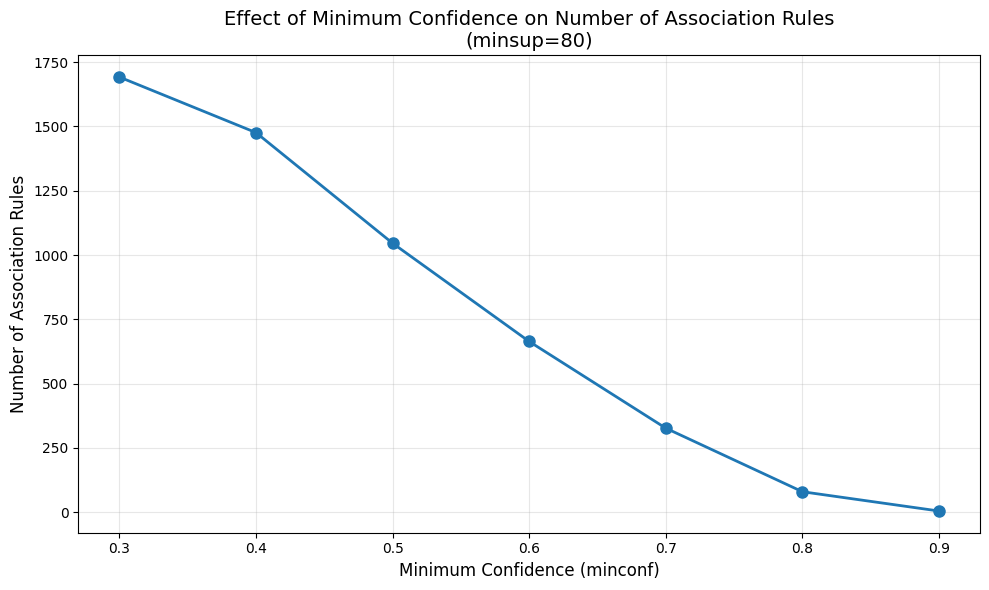

In [32]:
minsup = 80
minconf_range = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
rule_counts = []

print("Testing different minconf values...")
for minconf in minconf_range:
    _, rules = apriori_binary_format(binary_movies, minsup=minsup, minconf=minconf, debug=False)
    rule_counts.append(len(rules))
    print(f"minconf={minconf}: {len(rules)} rules")

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(minconf_range, rule_counts, marker='o', linewidth=2, markersize=8)
plt.xlabel('Minimum Confidence (minconf)', fontsize=12)
plt.ylabel('Number of Association Rules', fontsize=12)
plt.title('Effect of Minimum Confidence on Number of Association Rules\n(minsup=80)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**What happens when you increase minconf?**
  - The number of association rules decreases. As we require higher confidence
thresholds, fewer rules meet the criteria because fewer itemsets have
strong relationships.

**What happens when you decrease minconf?**
  - The number of association rules increases. Lower confidence thresholds allow weaker patterns to be considered valid rules.

**Why is this the case?**
  - Confidence measures how often an item appears when another is present. Higher minconf filters out weak correlations, keeping only the strongest predictive patterns. This is the "quality vs quantity" tradeoff - higher minconf gives fewer but more reliable rules.

```
On my honor, I declare the following resources:
1. Collaborators:
- N/A

2. Web Sources:
N/A

- ...

3. AI Tools:
- N/A

```

# 4.

Now, create a new function `apriori_random_sampling`, where you **implement random sampling as part of the apriori algorithm**:
- Start by copy-pasting `apriori_binary_df` and renaming it :)
- We discussed random sampling in class, which is a version of apriori where you randomly sample a subset of baskets (instead of working on the whole dataset with all of the baskets) to avoid the overhead of reading the entire set of baskets (which in practice, could amount to billions(!!!) of baskets). For this part, you should implement such a random sampling approach that takes a special parameter **alpha** that controls the size of the sample: e.g., alpha = 0.10 means to sample 10% of the baskets (our users, in this case).

Create a plot based on the results of running your function `apriori_random_sampling` multiple times with different `alpha` values:
- X-Axis: `alpha` (choose at least 3 values to try)
- Y-Axis: Total # of Association Rules Generated

Answer the following:
- What happens when you increase `alpha`?
- What happens when you decrease `alpha`?
- Why do you think this is the case? Explain.

Testing different alpha values...
alpha=0.1: 0 rules
alpha=0.2: 0 rules
alpha=0.3: 0 rules
alpha=0.4: 5 rules
alpha=0.5: 25 rules
alpha=0.6: 58 rules
alpha=0.7: 115 rules
alpha=0.8: 143 rules
alpha=0.9: 234 rules
alpha=1.0: 327 rules


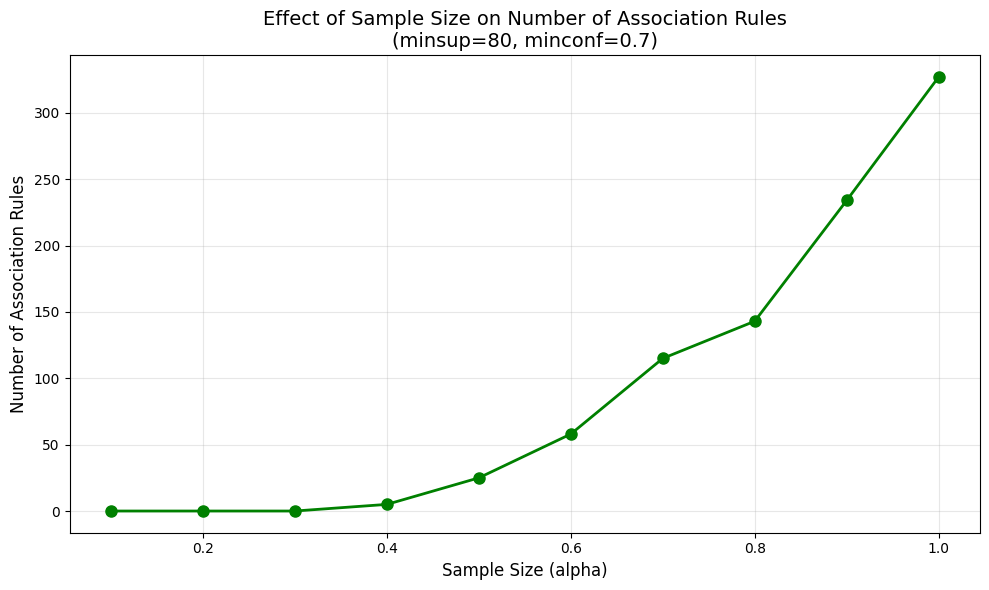

In [33]:
def apriori_random_sampling(data, minsup, minconf, alpha, debug=False, random_state=42):
    np.random.seed(random_state)

    n_users = len(data)
    n_sample = int(n_users * alpha)
    sampled_indices = np.random.choice(data.index, size=n_sample, replace=False)
    sampled_data = data.loc[sampled_indices]

    if debug:
        print(f"Sampled {n_sample} out of {n_users} users (alpha={alpha})")

    # Run apriori on sampled data
    itemsets, rules = apriori_binary_format(sampled_data, minsup=minsup, minconf=minconf, debug=debug)

    return itemsets, rules

minsup = 80
minconf = 0.7
alpha_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
rule_counts_alpha = []

print("Testing different alpha values...")
for alpha in alpha_range:
    _, rules = apriori_random_sampling(binary_movies, minsup=minsup, minconf=minconf, alpha=alpha, debug=False)
    rule_counts_alpha.append(len(rules))
    print(f"alpha={alpha}: {len(rules)} rules")

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(alpha_range, rule_counts_alpha, marker='o', linewidth=2, markersize=8, color='green')
plt.xlabel('Sample Size (alpha)', fontsize=12)
plt.ylabel('Number of Association Rules', fontsize=12)
plt.title('Effect of Sample Size on Number of Association Rules\n(minsup=80, minconf=0.7)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

```
On my honor, I declare the following resources:
1. Collaborators:
- N/A

2. Web Sources:
N/A

- ...

3. AI Tools:
- Claude: Used to help with a good "randomness" in the random sampling.
```

What happens when you increase alpha?
  - When you increase alpha, there are more rules. As we see, each time we increased the alpha percentage, the amount of association rules increased.

What happens when you decrease alpha?
  - When we decreased the alpha, the opposite is true. We lower the amount of association rules found.

Why do you think this is the case? Explain.
  - This is due to alpha controlling the sample size. When the sample size is smaller, association rules that are true might be missed, as its parsing a smaller subset of a larger dataset. The inverse is true where the subset the code grabs might indicate association rules that are true in the subset, but false in the larger picture. The trade off is computation time. The smaller the subset, the faster the computation time, but also increase the likelihood the rules are either false positives, or false negatives.

#5.

Now, let's see how `alpha` impacts the **total # of itemsets** generated!

Create a new version of your `apriori_random_sampling` function called `apriori_random_sampling_with_itemsets`, which also returns the total # of itemsets.

Create a plot based on the results of running your function `apriori_random_sampling` multiple times with different `alpha` values:
- X-Axis: `alpha` (choose at least 3 values to try, including `alpha=1.0` -- the entire dataset)
- Y-Axis: Total # of Itemsets Generated

Answer the following:
- What happens when you increase `alpha`?
- What happens when you decrease `alpha`?
- Why do you think this is the case? Explain.

Testing different alpha values for itemset counts...
alpha=0.1: 0 itemsets
alpha=0.2: 0 itemsets
alpha=0.3: 4 itemsets
alpha=0.4: 18 itemsets
alpha=0.5: 61 itemsets
alpha=0.6: 129 itemsets
alpha=0.7: 276 itemsets
alpha=0.8: 463 itemsets
alpha=0.9: 736 itemsets
alpha=1.0: 1049 itemsets


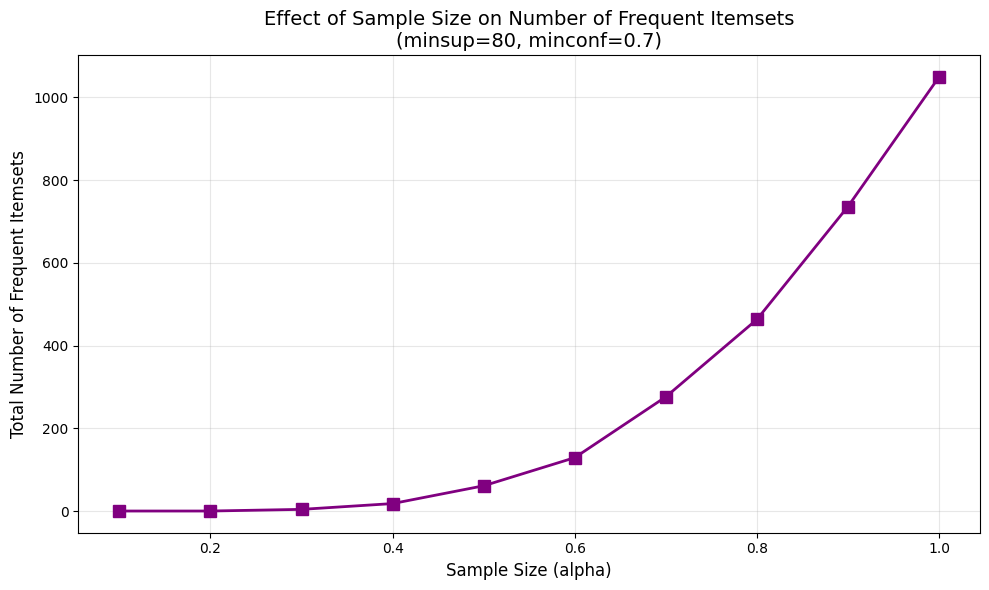

In [34]:
def apriori_random_sampling_with_itemsets(data, minsup, minconf, alpha, debug=False, random_state=42):
    np.random.seed(random_state)

    # Sample alpha% of users
    n_users = len(data)
    n_sample = int(n_users * alpha)
    sampled_indices = np.random.choice(data.index, size=n_sample, replace=False)
    sampled_data = data.loc[sampled_indices]

    # Run apriori
    itemsets, rules = apriori_binary_format(sampled_data, minsup=minsup, minconf=minconf, debug=debug)

    # Count total itemsets
    total_itemsets = len(itemsets[0]) + len(itemsets[1]) + len(itemsets[2])

    return itemsets, rules, total_itemsets

# Part 5: Plot alpha vs # of itemsets
alpha_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
itemset_counts = []

print("Testing different alpha values for itemset counts...")
for alpha in alpha_range:
    _, _, total_itemsets = apriori_random_sampling_with_itemsets(
        binary_movies, minsup=minsup, minconf=minconf, alpha=alpha, debug=False
    )
    itemset_counts.append(total_itemsets)
    print(f"alpha={alpha}: {total_itemsets} itemsets")

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(alpha_range, itemset_counts, marker='s', linewidth=2, markersize=8, color='purple')
plt.xlabel('Sample Size (alpha)', fontsize=12)
plt.ylabel('Total Number of Frequent Itemsets', fontsize=12)
plt.title('Effect of Sample Size on Number of Frequent Itemsets\n(minsup=80, minconf=0.7)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 6.
Now, let’s see how `minsup_sample` impacts false positives! Set `alpha=0.50` for this question so we can just focus on what happens when you change the value of `minsup_sample`.

Create a new version of `apriori_random_sampling_with_itemsets` called `apriori_random_sampling_with_itemsets_and_fps`, which also returns the number of false positives found in the sampled version of the dataset (as compared to the entire dataset).

Create a plot based on the results of running your function multiple times with different `minsup_sample` values:

* X-Axis:
  * minsup_sample (choose at least 3 values to try)
* Y-Axis (plot both and use a legend):
  * Total # of frequent itemsets found in the sample
  * Total # of false positives (itemsets frequent in the sample but not frequent in the full dataset)

Answer the following:
- What happens to the number of false positives when you increase `minsup_sample`?
- What happens to the number of false positives when you decrease `minsup_sample`?
- Why do you think this is the case? Explain.

Hint: A smaller support threshold (`minsup_sample`) makes it easier for noisy patterns to appear frequent.

Testing different minsup_sample values (alpha=0.5)...
minsup_sample=20: 15671 itemsets, 14622 false positives
minsup_sample=30: 4529 itemsets, 3480 false positives
minsup_sample=40: 1483 itemsets, 463 false positives
minsup_sample=50: 569 itemsets, 1 false positives
minsup_sample=60: 239 itemsets, 0 false positives
minsup_sample=70: 107 itemsets, 0 false positives
minsup_sample=80: 61 itemsets, 0 false positives


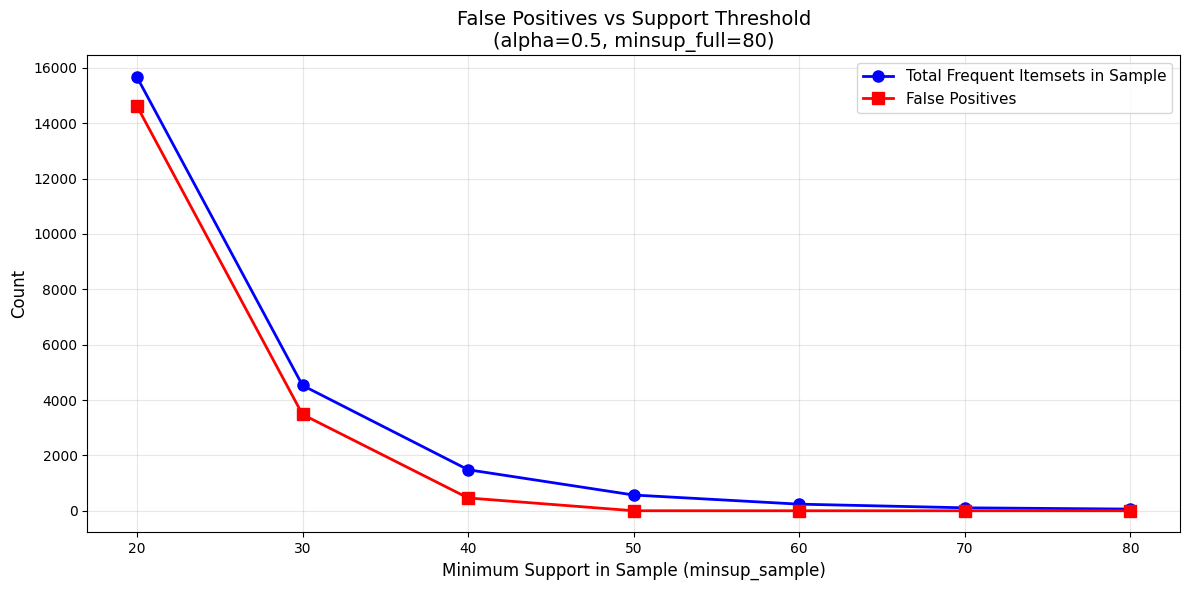

In [35]:
def apriori_random_sampling_with_itemsets_and_fps(data, minsup_sample, minconf, alpha, minsup_full=80, debug=False, random_state=42):
    np.random.seed(random_state)

    n_users = len(data)
    n_sample = int(n_users * alpha)
    sampled_indices = np.random.choice(data.index, size=n_sample, replace=False)
    sampled_data = data.loc[sampled_indices]

    itemsets_sample, _, _ = apriori_random_sampling_with_itemsets(
        sampled_data, minsup=minsup_sample, minconf=minconf, alpha=1.0, debug=False
    )

    itemsets_full, _, _ = apriori_random_sampling_with_itemsets(
        data, minsup=minsup_full, minconf=minconf, alpha=1.0, debug=False
    )


    sample_frequent = set()
    sample_frequent.update(itemsets_sample[0])  # 1-itemsets
    sample_frequent.update(itemsets_sample[1])  # 2-itemsets

    # Collect all frequent itemsets from full dataset
    full_frequent = set()
    full_frequent.update(itemsets_full[0])
    full_frequent.update([tuple(sorted(x)) if isinstance(x, tuple) else x for x in itemsets_full[1]])

    # False positives: frequent in sample but NOT frequent in full dataset
    false_positives = 0
    for item in sample_frequent:
        item_key = tuple(sorted(item)) if isinstance(item, tuple) else item
        if item_key not in full_frequent and item not in full_frequent:
            false_positives += 1

    total_sample_itemsets = len(sample_frequent)

    return total_sample_itemsets, false_positives

alpha = 0.5
minconf = 0.7
minsup_full = 80
minsup_sample_range = [20, 30, 40, 50, 60, 70, 80]

sample_itemsets_list = []
false_positives_list = []

print(f"Testing different minsup_sample values (alpha={alpha})...")
for minsup_sample in minsup_sample_range:
    total_sample, fps = apriori_random_sampling_with_itemsets_and_fps(
        binary_movies, minsup_sample=minsup_sample, minconf=minconf,
        alpha=alpha, minsup_full=minsup_full, debug=False
    )
    sample_itemsets_list.append(total_sample)
    false_positives_list.append(fps)
    print(f"minsup_sample={minsup_sample}: {total_sample} itemsets, {fps} false positives")

# Create plot
plt.figure(figsize=(12, 6))
plt.plot(minsup_sample_range, sample_itemsets_list, marker='o', linewidth=2, markersize=8, label='Total Frequent Itemsets in Sample', color='blue')
plt.plot(minsup_sample_range, false_positives_list, marker='s', linewidth=2, markersize=8, label='False Positives', color='red')
plt.xlabel('Minimum Support in Sample (minsup_sample)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title(f'False Positives vs Support Threshold\n(alpha={alpha}, minsup_full={minsup_full})', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

```
On my honor, I declare the following resources:
1. Collaborators:
- N/A

2. Web Sources:
N/A

- ...

3. AI Tools:
- Claude: Used to help with a good "randomness" in the random sampling.
```

**What happens to false positives when you increase minsup_sample?**
  - False positives decrease. Higher support thresholds filter out noise and
random patterns that appear frequent only due to sampling variance.

**What happens to false positives when you decrease minsup_sample?**
  - False positives increase. Lower thresholds allow more itemsets to be
considered "frequent" in the sample, including patterns that
don't hold in the full dataset.

**Why is this the case?**
  - A smaller support threshold makes it easier for random fluctuations in the
sample to create false patterns. In a sample of 300 users, an itemset might
appear 30 times by chance, but in the full 600 users it only appears 50 times.

# D [12pts]. Interview Questions

We now pretend this is a real job interview. Here's some guidance on how to answer these questions:

1. Briefly restate the question and state any assumptions you are making.

2. Explain your reasoning out loud, focusing on tradeoffs, limitations, and constraints.

3. As a principle, keep your answers as short and clear as they can be (while still answering the question).

4. Write/speak in a conversational but professional tone (avoid being overly formal). For speaking: speak at a reasonable pace and volume, speak clearly, pause when you need to, and practice making "eye contact" with the camera. Keep a confident, positive, and professional tone. *For additional coaching and practice, the University Writing Center provides individual appointments: https://writingcenter.tamu.edu/make-an-appointment.*

There may not be a single correct answer. We are grading whether your reasoning is reasonable and aware of limitations.


**Rubric**

[3pt] Clear understanding of the question; reasonable assumptions; thoughtful reasoning that acknowledges tradeoffs and limitations; clear, concise communication in a conversational but professional tone (for speaking: clear pace, volume, and articulation).

[1pt] Basic understanding but shallow reasoning or unclear assumptions; communication is somewhat unclear, overly verbose, or overly informal/formal.

[0pt] Minimal, unclear, or incorrect response; poor communication or unprofessional tone.

# 1.
How would you validate whether a discovered rule is actually useful in the real world?

**Answer:**

So we found a rule like "chips → salsa" with high confidence. But is it actually useful?

First thing I'd check is **lift.** Does the rule we found beat random chance? If people buy chips and salsa together at the same rate they'd buy them separately, the rule isn't telling us anything new.

Then I'd do **A/B testing**. Show salsa recommendations to half the people who buy chips, don't show it to the other half, and see if it actually increases sales.

# 2.
Why/when would we use association rule mining over a newer, fancier algorithm? How would you decide?

**Answer:**

When should we use Apriori instead of something like deep learning?

If I need to explain to a manager why we're rearranging shelves, "80% of chip buyers also buy salsa" makes sense to them. "The neural net says so" doesn't.

Also, association rules work fine with **smaller datasets**. If you only have a few thousand transactions, you don't need deep learning. Apriori will work just fine and run way faster.

# 3.

Why/when would you use an existing library over writing the code for the algorithm yourself?


**Answer:**

When should I use mlxtend vs writing my own code?

In production, definitely use a library. It's tested, optimized, and handles edge cases I haven't thought of. Writing production-quality code would take way longer. In addition, it is open-source, thus more eyes are on it and more contributors to enable future options.

# 4.
As a video: I run a grocery store. We need to figure out how to place items on the shelves. Walk me through how we can perform a market basket analysis to figure out what needs to change on the store shelves.

### TODO: <INSERT LINK>

# E [4pts]. What new questions do you have?
We want you to think bigger! Tell us what questions and curiosity this homework brings up for you.

**Rubric**

[4pt] Complete, thoughtful response.

[2pt] Partial response.

[0pt] Minimal response.

# 1.
What new questions do you have about association rule mining (in general) after this homework? Or, what topics are you curious about now? List at least 3.

1. **How do you find negative patterns?**
   We only looked at what people buy together. But how do we get things that people WON'T buy together? Ex: A !-> B??

2. **What about brand new products?**
   All our rules came from historical data. But what if a store launches a completely new product with zero purchase history? How do you recommend something that's never been bought before?

3. **How do you make this work with time?**
   Our analysis ignored when things were bought. But people buy sunscreen in summer and hot chocolate in winter. Or they buy diapers, then baby food months later. How do you capture "if you bought A last month, you'll probably want B now"?

